In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk
import string
import re
from nltk.corpus import stopwords
import time
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score

In [3]:
df = pd.read_csv('./netflix_reviews.csv')
df

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,5d12b3ec-f34d-4711-8280-eca2604d559a,Dineo Nickel,please bring back some old shows that got a lo...,4,0,8.115.2 build 6 50688,2024-05-25 22:40:09,8.115.2 build 6 50688
1,9ae077fb-c2f1-4ee3-8e68-35be80d704a1,Issa tunde,Thank you,5,0,8.112.1 build 6 50665,2024-05-25 22:37:12,8.112.1 build 6 50665
2,b89f2695-e803-4e9a-a9ec-c6156642d892,pro gamer (Pratham),geat free games but we wantMinecraft java edition,5,0,8.109.0 build 7 50647,2024-05-25 22:30:33,8.109.0 build 7 50647
3,687c952f-4b53-43ab-9e8f-bae26ad875d0,Devon Bryant,Won't open on my phone....,1,1,8.115.2 build 6 50688,2024-05-25 22:30:16,8.115.2 build 6 50688
4,da1f671f-dd67-45e0-8225-575bcd373bed,Liz Gichora,"User friendly, helpful.",5,0,8.115.2 build 6 50688,2024-05-25 22:30:11,8.115.2 build 6 50688
...,...,...,...,...,...,...,...,...
110413,a760ead9-e7aa-4ed1-a651-5c37c3600dac,A Google user,i really like it! there are so many movies and...,5,0,NaN,2019-08-03 15:06:03,NaN
110414,4957f9e7-d7f4-4a52-9764-031cebcac83f,Captain Jeoy,I love Netflix. I always enjoy my time using it.,5,0,8.34.0 build 4 50250,2022-08-15 16:16:30,8.34.0 build 4 50250
110415,9acf7586-7abf-4b50-8c50-3ede3b2a42c4,Suryansh,Sound quality is very slow of movies,1,0,NaN,2020-08-17 07:26:58,NaN
110416,32870f7f-c461-4256-b602-75244ca60248,A Google user,Rate is very expensive.. bcos we see netflix s...,1,0,7.17.0 build 13 34346,2019-07-21 09:41:42,7.17.0 build 13 34346


- content: users' reviews
- score: rating of satisfaction
- thumbsUpCount: total likes from other users

In [4]:
df = df[['content', 'score', 'thumbsUpCount', 'at']]
df

,content,score,thumbsUpCount,at
0,please bring back some old shows that got a lo...,4,0,2024-05-25 22:40:09
1,Thank you,5,0,2024-05-25 22:37:12
2,geat free games but we wantMinecraft java edition,5,0,2024-05-25 22:30:33
3,Won't open on my phone....,1,1,2024-05-25 22:30:16
4,"User friendly, helpful.",5,0,2024-05-25 22:30:11
...,...,...,...,...
110413,i really like it! there are so many movies and...,5,0,2019-08-03 15:06:03
110414,I love Netflix. I always enjoy my time using it.,5,0,2022-08-15 16:16:30
110415,Sound quality is very slow of movies,1,0,2020-08-17 07:26:58
110416,Rate is very expensive.. bcos we see netflix s...,1,0,2019-07-21 09:41:42


In [5]:
rating_dist = df['score'].value_counts()
rating_dist

score
1    43225
5    31147
4    13677
3    11772
2    10597
Name: count, dtype: int64

## distribution of ratings

Text(0, 0.5, 'Number of Reviews')

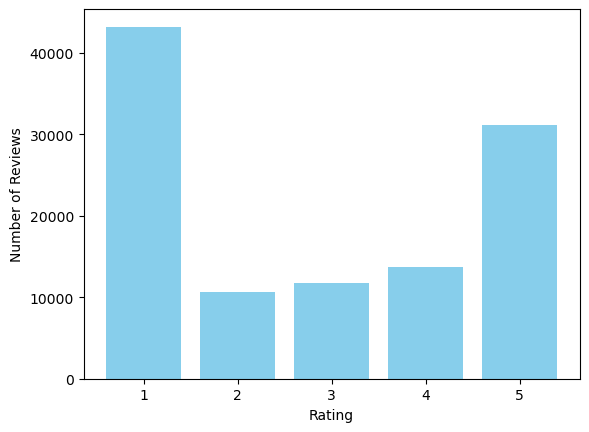

In [6]:
plt.bar(rating_dist.index, rating_dist.values, color = 'skyblue')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')

## filtering out missing value(content)

In [7]:
df.shape

(110418, 4)

In [8]:
df.isna().sum()

content          2
score            0
thumbsUpCount    0
at               0
dtype: int64

In [9]:
df.dropna(inplace=True)
df.shape

/tmp/ipykernel_9732/2053667463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


(110416, 4)

<h4>Approaches

- try all 5 scale of ratings
- bond 1,2 as negative emotion, 3 as neutral, bond 4,5 as positive emotion
- prediction:
1. Bag of words
2. TF-IDF
3. Word embeddings: Word2Vec
- adding thumbsIpCount vs not including thumbsIpCount

In [10]:
df['score'].value_counts()

score
1    43225
5    31146
4    13677
3    11772
2    10596
Name: count, dtype: int64

## distribution of ratings-bonded

/tmp/ipykernel_9732/301982692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score_bond'] = df['score'].apply(lambda x: "negative" if x < 3 else ("positive" if x > 3 else "neutral"))


Text(0, 0.5, 'Number of Reviews')

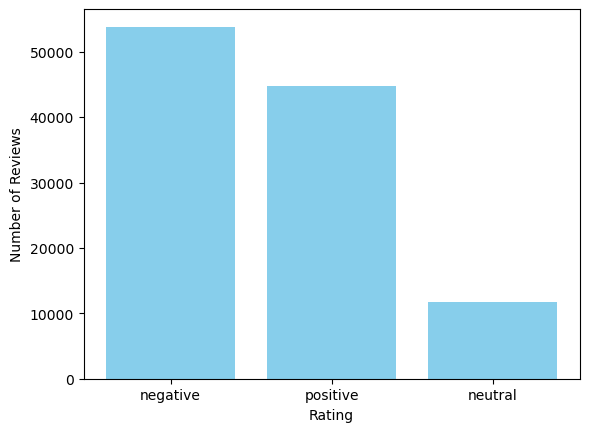

In [11]:
df['score_bond'] = df['score'].apply(lambda x: "negative" if x < 3 else ("positive" if x > 3 else "neutral"))
rating_bond_dist = df['score_bond'].value_counts()
plt.bar(rating_bond_dist.index, rating_bond_dist.values, color = 'skyblue')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')

## distribution of thumbsUpCount

In [12]:
df['thumbsUpCount'].describe()

count    110416.000000
mean         10.685879
std         101.547524
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        8032.000000
Name: thumbsUpCount, dtype: float64

In [13]:
top_10_percent_threshold = df['thumbsUpCount'].quantile(0.9)
top_10_percent_threshold

4.0

In [14]:
a = df[df['thumbsUpCount'] <= top_10_percent_threshold]['thumbsUpCount'].value_counts()
a.sum()

99598

In [15]:
df2 = df[df['thumbsUpCount'] <= top_10_percent_threshold].copy()
df2.shape

(99598, 5)

Text(0, 0.5, 'Number of ThumbsUp')

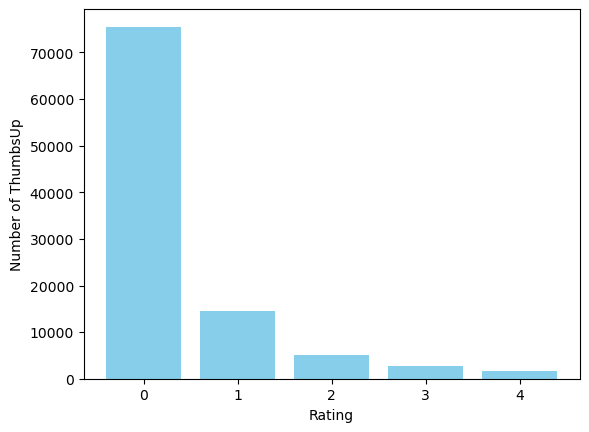

In [16]:
plt.bar(a.index, a.values, color = 'skyblue')
plt.xlabel('Rating')
plt.ylabel('Number of ThumbsUp')

In [17]:
top_20_percent_threshold = df['thumbsUpCount'].quantile(0.8)
top_20_percent_threshold

1.0

In [18]:
b = df[df['thumbsUpCount'] <= top_20_percent_threshold]['thumbsUpCount'].value_counts()
b.sum()

89956

In [19]:
df3 = df[df['thumbsUpCount'] <= top_20_percent_threshold].copy()
df3.shape

(89956, 5)

Text(0, 0.5, 'Number of ThumbsUp')

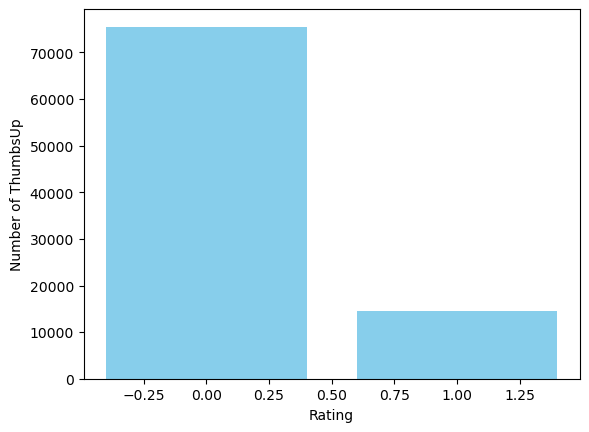

In [20]:
plt.bar(b.index, b.values, color = 'skyblue')
plt.xlabel('Rating')
plt.ylabel('Number of ThumbsUp')

## remove emoji

In [21]:
def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['content'] = df['content'].apply(remove_emojis)
df['content']
##
df2['content'] = df2['content'].apply(remove_emojis)
df2['content']
##
df3['content'] = df3['content'].apply(remove_emojis)
df3['content']

/tmp/ipykernel_9732/4278455998.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['content'].apply(remove_emojis)


0         please bring back some old shows that got a lo...
1                                                 Thank you
2         geat free games but we wantMinecraft java edition
3                                Won't open on my phone....
4                                   User friendly, helpful.
                                ...                        
110413    i really like it! there are so many movies and...
110414     I love Netflix. I always enjoy my time using it.
110415                 Sound quality is very slow of movies
110416    Rate is very expensive.. bcos we see netflix s...
110417    this app is awesome for english movies ,series...
Name: content, Length: 89956, dtype: object

In [22]:
ps = PorterStemmer() 
stop = set(stopwords.words('english'))

def pre_processing_by_nltk(doc, need_sent = False):
    sentences = sent_tokenize(doc)
    tokens = []
    for sent in sentences:
        words = word_tokenize(sent)
        words = [ps.stem(word) for word in words]
        tokens += words
    return [w.lower() for w in tokens if w.lower() not in stop]

In [23]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
display(train_data.head(3))
display(test_data.head(3))
##
train_data2, test_data2 = train_test_split(df2, test_size=0.2, random_state=42, shuffle=True)
# display(train_data2.head(3))
# display(test_data2.head(3))
##
train_data3, test_data3 = train_test_split(df3, test_size=0.2, random_state=42, shuffle=True)
# display(train_data3.head(3))
# display(test_data3.head(3))

,content,score,thumbsUpCount,at,score_bond
66521,Sad that this company has to resort to creativ...,1,1,2023-07-30 14:42:58,negative
75965,Even though deleted the login account But stil...,1,0,2021-06-03 17:25:24,negative
49525,Flicks Netflix is my favorite movie and I can ...,5,0,2023-02-05 09:43:53,positive


,content,score,thumbsUpCount,at,score_bond
2450,App stopped working a few weeks ago and hasn't...,1,1,2024-05-11 06:51:36,negative
25966,"You can't sort ""My List"" by neither runtime no...",1,0,2024-02-04 23:02:06,negative
25783,Gta game not work for my device and problem is...,2,0,2023-12-24 11:08:40,negative


In [24]:
binary_vectorizer = CountVectorizer(binary=True, tokenizer=pre_processing_by_nltk)
X_train_binary = binary_vectorizer.fit_transform(train_data['content'])
X_test_binary = binary_vectorizer.transform(test_data['content'])
##
binary_vectorizer2 = CountVectorizer(binary=True, tokenizer=pre_processing_by_nltk)
X_train_binary2 = binary_vectorizer.fit_transform(train_data2['content'])
X_test_binary2 = binary_vectorizer.transform(test_data2['content'])
##
binary_vectorizer3 = CountVectorizer(binary=True, tokenizer=pre_processing_by_nltk)
X_train_binary3 = binary_vectorizer.fit_transform(train_data3['content'])
X_test_binary3 = binary_vectorizer.transform(test_data3['content'])

/opt/conda/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [25]:
tf_vectorizer = CountVectorizer(binary=False, tokenizer=pre_processing_by_nltk)
X_train_tf = tf_vectorizer.fit_transform(train_data['content'])
X_test_tf = tf_vectorizer.transform(test_data['content'])
##
tf_vectorizer2 = CountVectorizer(binary=False, tokenizer=pre_processing_by_nltk)
X_train_tf2 = tf_vectorizer.fit_transform(train_data2['content'])
X_test_tf2 = tf_vectorizer.transform(test_data2['content'])
##
tf_vectorizer3 = CountVectorizer(binary=False, tokenizer=pre_processing_by_nltk)
X_train_tf3 = tf_vectorizer.fit_transform(train_data3['content'])
X_test_tf3 = tf_vectorizer.transform(test_data3['content'])

In [26]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=pre_processing_by_nltk)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['content'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['content'])
##
tfidf_vectorizer2 = TfidfVectorizer(tokenizer=pre_processing_by_nltk)
X_train_tfidf2 = tfidf_vectorizer.fit_transform(train_data2['content'])
X_test_tfidf2 = tfidf_vectorizer.transform(test_data2['content'])
##
tfidf_vectorizer3 = TfidfVectorizer(tokenizer=pre_processing_by_nltk)
X_train_tfidf3 = tfidf_vectorizer.fit_transform(train_data3['content'])
X_test_tfidf3 = tfidf_vectorizer.transform(test_data3['content'])

In [27]:
Y_train = train_data['score']
Y_test = test_data['score']
##
Y_train2 = train_data2['score']
Y_test2 = test_data2['score']
##
Y_train3 = train_data3['score']
Y_test3 = test_data3['score']

## using original rating

In [28]:
def train_and_test(X_train, X_test, y_train, y_test, model_name):
    clf = LogisticRegression(max_iter=1000, solver='saga', random_state=42,  class_weight='balanced')
    clf.fit(X_train, y_train)
    
    y_test_pred = clf.predict(X_test)
    y_test_proba = clf.predict_proba(X_test)

    auroc = roc_auc_score(y_test, y_test_proba, multi_class="ovr")
    macro_f1 = f1_score(y_test, y_test_pred, average='macro')
    micro_f1 = f1_score(y_test, y_test_pred, average='micro')

    print(f"Model: {model_name}")
    print(f"Validation AUROC: {auroc:.4f}")
    print(f"Validation Macro-F1: {macro_f1:.4f}")
    print(f"Validation Micro-F1: {micro_f1:.4f}")
    print("-" * 50)

    return clf 

clf_binary = train_and_test(X_train_binary, X_test_binary, Y_train, Y_test, "Binary Representation")
clf_tf = train_and_test(X_train_tf, X_test_tf, Y_train, Y_test, "Term Frequency Representation")
clf_tfidf = train_and_test(X_train_tfidf, X_test_tfidf, Y_train, Y_test, "TF-IDF Representation")

Model: Binary Representation
Validation AUROC: 0.7892
Validation Macro-F1: 0.4583
Validation Micro-F1: 0.5587
--------------------------------------------------


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model: Term Frequency Representation
Validation AUROC: 0.8030
Validation Macro-F1: 0.4683
Validation Micro-F1: 0.5647
--------------------------------------------------
Model: TF-IDF Representation
Validation AUROC: 0.8076
Validation Macro-F1: 0.4654
Validation Micro-F1: 0.5574
--------------------------------------------------


In [29]:
y_test_proba_or_binary = clf_binary.predict_proba(X_test_binary)
y_test_pred_or_binary = clf_binary.predict(X_test_binary)
auroc_or_binary = roc_auc_score(Y_test, y_test_proba_or_binary, multi_class="ovr")
macro_f1_or_binary = f1_score(Y_test, y_test_pred_or_binary, average='macro')
micro_f1_or_binary = f1_score(Y_test, y_test_pred_or_binary, average='micro')

y_test_proba_or_tf = clf_tf.predict_proba(X_test_tf)
y_test_pred_or_tf = clf_tf.predict(X_test_tf)
auroc_or_tf = roc_auc_score(Y_test, y_test_proba_or_tf, multi_class="ovr")
macro_f1_or_tf = f1_score(Y_test, y_test_pred_or_tf, average='macro')
micro_f1_or_tf = f1_score(Y_test, y_test_pred_or_tf, average='micro')

y_test_proba_or_tfidf = clf_tfidf.predict_proba(X_test_tfidf)
y_test_pred_or_tfidf = clf_tfidf.predict(X_test_tfidf)
auroc_or_tfidf = roc_auc_score(Y_test, y_test_proba_or_tfidf, multi_class="ovr")
macro_f1_or_tfidf = f1_score(Y_test, y_test_pred_or_tfidf, average='macro')
micro_f1_or_tfidf = f1_score(Y_test, y_test_pred_or_tfidf, average='micro')

## using original rating with thumbsUpCount feature

In [30]:
from scipy.sparse import hstack

def train_and_test(X_train, X_test, y_train, y_test, model_name):
    clf = LogisticRegression(max_iter=1000, solver='saga', random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)
    
    y_test_pred = clf.predict(X_test)
    y_test_proba = clf.predict_proba(X_test)

    auroc = roc_auc_score(y_test, y_test_proba, multi_class="ovr")
    macro_f1 = f1_score(y_test, y_test_pred, average='macro')
    micro_f1 = f1_score(y_test, y_test_pred, average='micro')

    print(f"Model: {model_name}")
    print(f"Validation AUROC: {auroc:.4f}")
    print(f"Validation Macro-F1: {macro_f1:.4f}")
    print(f"Validation Micro-F1: {micro_f1:.4f}")
    print("-" * 50)

    return clf 

train_thumbs = train_data["thumbsUpCount"].values.reshape(-1, 1)
test_thumbs = test_data["thumbsUpCount"].values.reshape(-1, 1)

X_train_binary = hstack((X_train_binary, train_thumbs))
X_test_binary = hstack((X_test_binary, test_thumbs))

X_train_tf = hstack((X_train_tf, train_thumbs))
X_test_tf = hstack((X_test_tf, test_thumbs))

X_train_tfidf = hstack((X_train_tfidf, train_thumbs))
X_test_tfidf = hstack((X_test_tfidf, test_thumbs))

clf_binary = train_and_test(X_train_binary, X_test_binary, Y_train, Y_test, "Binary Representation")
clf_tf = train_and_test(X_train_tf, X_test_tf, Y_train, Y_test, "Term Frequency Representation")
clf_tfidf = train_and_test(X_train_tfidf, X_test_tfidf, Y_train, Y_test, "TF-IDF Representation")

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model: Binary Representation
Validation AUROC: 0.7361
Validation Macro-F1: 0.3685
Validation Micro-F1: 0.4353
--------------------------------------------------


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model: Term Frequency Representation
Validation AUROC: 0.7070
Validation Macro-F1: 0.3546
Validation Micro-F1: 0.4307
--------------------------------------------------
Model: TF-IDF Representation
Validation AUROC: 0.7311
Validation Macro-F1: 0.3859
Validation Micro-F1: 0.4670
--------------------------------------------------


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [31]:
y_test_proba_or_binary_thumbs = clf_binary.predict_proba(X_test_binary)
y_test_pred_or_binary_thumbs = clf_binary.predict(X_test_binary)
auroc_or_binary_thumbs = roc_auc_score(Y_test, y_test_proba_or_binary_thumbs, multi_class="ovr")
macro_f1_or_binary_thumbs = f1_score(Y_test, y_test_pred_or_binary_thumbs, average='macro')
micro_f1_or_binary_thumbs = f1_score(Y_test, y_test_pred_or_binary_thumbs, average='micro')

y_test_proba_or_tf_thumbs = clf_tf.predict_proba(X_test_tf)
y_test_pred_or_tf_thumbs = clf_tf.predict(X_test_tf)
auroc_or_tf_thumbs = roc_auc_score(Y_test, y_test_proba_or_tf_thumbs, multi_class="ovr")
macro_f1_or_tf_thumbs = f1_score(Y_test, y_test_pred_or_tf_thumbs, average='macro')
micro_f1_or_tf_thumbs = f1_score(Y_test, y_test_pred_or_tf_thumbs, average='micro')

y_test_proba_or_tfidf_thumbs = clf_tfidf.predict_proba(X_test_tfidf)
y_test_pred_or_tfidf_thumbs = clf_tfidf.predict(X_test_tfidf)
auroc_or_tfidf_thumbs = roc_auc_score(Y_test, y_test_proba_or_tfidf_thumbs, multi_class="ovr")
macro_f1_or_tfidf_thumbs = f1_score(Y_test, y_test_pred_or_tfidf_thumbs, average='macro')
micro_f1_or_tfidf_thumbs = f1_score(Y_test, y_test_pred_or_tfidf_thumbs, average='micro')

In [32]:
from scipy.sparse import hstack

def train_and_test(X_train, X_test, y_train, y_test, model_name):
    clf = LogisticRegression(max_iter=1000, solver='saga', random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)
    
    y_test_pred = clf.predict(X_test)
    y_test_proba = clf.predict_proba(X_test)

    auroc = roc_auc_score(y_test, y_test_proba, multi_class="ovr")
    macro_f1 = f1_score(y_test, y_test_pred, average='macro')
    micro_f1 = f1_score(y_test, y_test_pred, average='micro')

    print(f"Model: {model_name}")
    print(f"Validation AUROC: {auroc:.4f}")
    print(f"Validation Macro-F1: {macro_f1:.4f}")
    print(f"Validation Micro-F1: {micro_f1:.4f}")
    print("-" * 50)

    return clf 

train_thumbs2 = train_data2["thumbsUpCount"].values.reshape(-1, 1)
test_thumbs2 = test_data2["thumbsUpCount"].values.reshape(-1, 1)

X_train_binary2 = hstack((X_train_binary2, train_thumbs2))
X_test_binary2 = hstack((X_test_binary2, test_thumbs2))

X_train_tf2 = hstack((X_train_tf2, train_thumbs2))
X_test_tf2 = hstack((X_test_tf2, test_thumbs2))

X_train_tfidf2 = hstack((X_train_tfidf2, train_thumbs2))
X_test_tfidf2 = hstack((X_test_tfidf2, test_thumbs2))

clf_binary2 = train_and_test(X_train_binary2, X_test_binary2, Y_train2, Y_test2, "Binary Representation")
clf_tf2 = train_and_test(X_train_tf2, X_test_tf2, Y_train2, Y_test2, "Term Frequency Representation")
clf_tfidf2 = train_and_test(X_train_tfidf2, X_test_tfidf2, Y_train2, Y_test2, "TF-IDF Representation")

Model: Binary Representation
Validation AUROC: 0.7901
Validation Macro-F1: 0.4499
Validation Micro-F1: 0.5596
--------------------------------------------------


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model: Term Frequency Representation
Validation AUROC: 0.8041
Validation Macro-F1: 0.4643
Validation Micro-F1: 0.5660
--------------------------------------------------
Model: TF-IDF Representation
Validation AUROC: 0.8069
Validation Macro-F1: 0.4617
Validation Micro-F1: 0.5628
--------------------------------------------------


In [33]:
from scipy.sparse import hstack

def train_and_test(X_train, X_test, y_train, y_test, model_name):
    clf = LogisticRegression(max_iter=1000, solver='saga', random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)
    
    y_test_pred = clf.predict(X_test)
    y_test_proba = clf.predict_proba(X_test)

    auroc = roc_auc_score(y_test, y_test_proba, multi_class="ovr")
    macro_f1 = f1_score(y_test, y_test_pred, average='macro')
    micro_f1 = f1_score(y_test, y_test_pred, average='micro')

    print(f"Model: {model_name}")
    print(f"Validation AUROC: {auroc:.4f}")
    print(f"Validation Macro-F1: {macro_f1:.4f}")
    print(f"Validation Micro-F1: {micro_f1:.4f}")
    print("-" * 50)

    return clf 

train_thumbs3 = train_data3["thumbsUpCount"].values.reshape(-1, 1)
test_thumbs3 = test_data3["thumbsUpCount"].values.reshape(-1, 1)

X_train_binary3 = hstack((X_train_binary3, train_thumbs3))
X_test_binary3 = hstack((X_test_binary3, test_thumbs3))

X_train_tf3 = hstack((X_train_tf3, train_thumbs3))
X_test_tf3 = hstack((X_test_tf3, test_thumbs3))

X_train_tfidf3 = hstack((X_train_tfidf3, train_thumbs3))
X_test_tfidf3 = hstack((X_test_tfidf3, test_thumbs3))

clf_binary3 = train_and_test(X_train_binary3, X_test_binary3, Y_train3, Y_test3, "Binary Representation")
clf_tf3 = train_and_test(X_train_tf3, X_test_tf3, Y_train3, Y_test3, "Term Frequency Representation")
clf_tfidf3 = train_and_test(X_train_tfidf3, X_test_tfidf3, Y_train3, Y_test3, "TF-IDF Representation")

Model: Binary Representation
Validation AUROC: 0.7916
Validation Macro-F1: 0.4595
Validation Micro-F1: 0.5647
--------------------------------------------------


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model: Term Frequency Representation
Validation AUROC: 0.8049
Validation Macro-F1: 0.4674
Validation Micro-F1: 0.5678
--------------------------------------------------
Model: TF-IDF Representation
Validation AUROC: 0.8073
Validation Macro-F1: 0.4636
Validation Micro-F1: 0.5611
--------------------------------------------------


In [34]:
y_test_proba_or_binary_thumbs3 = clf_binary3.predict_proba(X_test_binary3)
y_test_pred_or_binary_thumbs3 = clf_binary3.predict(X_test_binary3)
auroc_or_binary_thumbs3 = roc_auc_score(Y_test3, y_test_proba_or_binary_thumbs3, multi_class="ovr")
macro_f1_or_binary_thumbs3 = f1_score(Y_test3, y_test_pred_or_binary_thumbs3, average='macro')
micro_f1_or_binary_thumbs3 = f1_score(Y_test3, y_test_pred_or_binary_thumbs3, average='micro')

y_test_proba_or_tf_thumbs3 = clf_tf3.predict_proba(X_test_tf3)
y_test_pred_or_tf_thumbs3 = clf_tf3.predict(X_test_tf3)
auroc_or_tf_thumbs3 = roc_auc_score(Y_test3, y_test_proba_or_tf_thumbs3, multi_class="ovr")
macro_f1_or_tf_thumbs3 = f1_score(Y_test3, y_test_pred_or_tf_thumbs3, average='macro')
micro_f1_or_tf_thumbs3 = f1_score(Y_test3, y_test_pred_or_tf_thumbs3, average='micro')

y_test_proba_or_tfidf_thumbs3 = clf_tfidf3.predict_proba(X_test_tfidf3)
y_test_pred_or_tfidf_thumbs3 = clf_tfidf3.predict(X_test_tfidf3)
auroc_or_tfidf_thumbs3 = roc_auc_score(Y_test3, y_test_proba_or_tfidf_thumbs3, multi_class="ovr")
macro_f1_or_tfidf_thumbs3 = f1_score(Y_test3, y_test_pred_or_tfidf_thumbs3, average='macro')
micro_f1_or_tfidf_thumbs3 = f1_score(Y_test3, y_test_pred_or_tfidf_thumbs3, average='micro')

## using bonded rating

In [35]:
Y_train_bond = train_data['score_bond']
Y_test_bond = test_data['score_bond']
##
Y_train_bond2 = train_data2['score_bond']
Y_test_bond2 = test_data2['score_bond']
##
Y_train_bond3 = train_data3['score_bond']
Y_test_bond3 = test_data3['score_bond']

In [36]:
def train_and_test(X_train, X_test, y_train, y_test, model_name):
    clf = LogisticRegression(max_iter=1000, solver='saga', random_state=42,  class_weight='balanced')
    clf.fit(X_train, y_train)
    
    y_test_pred = clf.predict(X_test)
    y_test_proba = clf.predict_proba(X_test)

    auroc = roc_auc_score(y_test, y_test_proba, multi_class="ovr")
    macro_f1 = f1_score(y_test, y_test_pred, average='macro')
    micro_f1 = f1_score(y_test, y_test_pred, average='micro')

    print(f"Model: {model_name}")
    print(f"Validation AUROC: {auroc:.4f}")
    print(f"Validation Macro-F1: {macro_f1:.4f}")
    print(f"Validation Micro-F1: {micro_f1:.4f}")
    print("-" * 50)

    return clf 

clf_binary = train_and_test(X_train_binary, X_test_binary, Y_train_bond, Y_test_bond, "Binary Representation")
clf_tf = train_and_test(X_train_tf, X_test_tf, Y_train_bond, Y_test_bond, "Term Frequency Representation")
clf_tfidf = train_and_test(X_train_tfidf, X_test_tfidf, Y_train_bond, Y_test_bond, "TF-IDF Representation")

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model: Binary Representation
Validation AUROC: 0.7858
Validation Macro-F1: 0.5677
Validation Micro-F1: 0.6510
--------------------------------------------------


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model: Term Frequency Representation
Validation AUROC: 0.7603
Validation Macro-F1: 0.5424
Validation Micro-F1: 0.6242
--------------------------------------------------


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model: TF-IDF Representation
Validation AUROC: 0.7874
Validation Macro-F1: 0.5796
Validation Micro-F1: 0.6676
--------------------------------------------------


In [37]:
y_test_proba_bond_binary = clf_binary.predict_proba(X_test_binary)
y_test_pred_bond_binary = clf_binary.predict(X_test_binary)
auroc_bond_binary = roc_auc_score(Y_test_bond, y_test_proba_bond_binary, multi_class="ovr")
macro_f1_bond_binary = f1_score(Y_test_bond, y_test_pred_bond_binary, average='macro')
micro_f1_bond_binary = f1_score(Y_test_bond, y_test_pred_bond_binary, average='micro')

y_test_proba_bond_tf = clf_tf.predict_proba(X_test_tf)
y_test_pred_bond_tf = clf_tf.predict(X_test_tf)
auroc_bond_tf = roc_auc_score(Y_test_bond, y_test_proba_bond_tf, multi_class="ovr")
macro_f1_bond_tf = f1_score(Y_test_bond, y_test_pred_bond_tf, average='macro')
micro_f1_bond_tf = f1_score(Y_test_bond, y_test_pred_bond_tf, average='micro')

y_test_proba_bond_tfidf = clf_tfidf.predict_proba(X_test_tfidf)
y_test_pred_bond_tfidf = clf_tfidf.predict(X_test_tfidf)
auroc_bond_tfidf = roc_auc_score(Y_test_bond, y_test_proba_bond_tfidf, multi_class="ovr")
macro_f1_bond_tfidf = f1_score(Y_test_bond, y_test_pred_bond_tfidf, average='macro')
micro_f1_bond_tfidf = f1_score(Y_test_bond, y_test_pred_bond_tfidf, average='micro')

## using bonded rating with thumbsUpCount feature

In [38]:
def train_and_test(X_train, X_test, y_train, y_test, model_name):
    clf = LogisticRegression(max_iter=1000, solver='saga', random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)
    
    y_test_pred = clf.predict(X_test)
    y_test_proba = clf.predict_proba(X_test)

    auroc = roc_auc_score(y_test, y_test_proba, multi_class="ovr")
    macro_f1 = f1_score(y_test, y_test_pred, average='macro')
    micro_f1 = f1_score(y_test, y_test_pred, average='micro')

    print(f"Model: {model_name}")
    print(f"Validation AUROC: {auroc:.4f}")
    print(f"Validation Macro-F1: {macro_f1:.4f}")
    print(f"Validation Micro-F1: {micro_f1:.4f}")
    print("-" * 50)

    return clf 

train_thumbs = train_data["thumbsUpCount"].values.reshape(-1, 1)
test_thumbs = test_data["thumbsUpCount"].values.reshape(-1, 1)

X_train_binary = hstack((X_train_binary, train_thumbs))
X_test_binary = hstack((X_test_binary, test_thumbs))

X_train_tf = hstack((X_train_tf, train_thumbs))
X_test_tf = hstack((X_test_tf, test_thumbs))

X_train_tfidf = hstack((X_train_tfidf, train_thumbs))
X_test_tfidf = hstack((X_test_tfidf, test_thumbs))

clf_binary = train_and_test(X_train_binary, X_test_binary, Y_train_bond, Y_test_bond, "Binary Representation")
clf_tf = train_and_test(X_train_tf, X_test_tf, Y_train_bond, Y_test_bond, "Term Frequency Representation")
clf_tfidf = train_and_test(X_train_tfidf, X_test_tfidf, Y_train_bond, Y_test_bond, "TF-IDF Representation")

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model: Binary Representation
Validation AUROC: 0.7801
Validation Macro-F1: 0.5554
Validation Micro-F1: 0.6331
--------------------------------------------------


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model: Term Frequency Representation
Validation AUROC: 0.7410
Validation Macro-F1: 0.5193
Validation Micro-F1: 0.6026
--------------------------------------------------


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model: TF-IDF Representation
Validation AUROC: 0.7808
Validation Macro-F1: 0.5710
Validation Micro-F1: 0.6505
--------------------------------------------------


In [39]:
y_test_proba_bond_binary_thumb = clf_binary.predict_proba(X_test_binary)
y_test_pred_bond_binary_thumb = clf_binary.predict(X_test_binary)
auroc_bond_binary_thumb = roc_auc_score(Y_test_bond, y_test_proba_bond_binary_thumb, multi_class="ovr")
macro_f1_bond_binary_thumb = f1_score(Y_test_bond, y_test_pred_bond_binary_thumb, average='macro')
micro_f1_bond_binary_thumb = f1_score(Y_test_bond, y_test_pred_bond_binary_thumb, average='micro')

y_test_proba_bond_tf_thumb = clf_tf.predict_proba(X_test_tf)
y_test_pred_bond_tf_thumb = clf_tf.predict(X_test_tf)
auroc_bond_tf_thumb = roc_auc_score(Y_test_bond, y_test_proba_bond_tf_thumb, multi_class="ovr")
macro_f1_bond_tf_thumb = f1_score(Y_test_bond, y_test_pred_bond_tf_thumb, average='macro')
micro_f1_bond_tf_thumb = f1_score(Y_test_bond, y_test_pred_bond_tf_thumb, average='micro')

y_test_proba_bond_tfidf_thumb = clf_tfidf.predict_proba(X_test_tfidf)
y_test_pred_bond_tfidf_thumb = clf_tfidf.predict(X_test_tfidf)
auroc_bond_tfidf_thumb = roc_auc_score(Y_test_bond, y_test_proba_bond_tfidf_thumb, multi_class="ovr")
macro_f1_bond_tfidf_thumb = f1_score(Y_test_bond, y_test_pred_bond_tfidf_thumb, average='macro')
micro_f1_bond_tfidf_thumb = f1_score(Y_test_bond, y_test_pred_bond_tfidf_thumb, average='micro')

In [40]:
def train_and_test(X_train, X_test, y_train, y_test, model_name):
    clf = LogisticRegression(max_iter=1000, solver='saga', random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)
    
    y_test_pred = clf.predict(X_test)
    y_test_proba = clf.predict_proba(X_test)

    auroc = roc_auc_score(y_test, y_test_proba, multi_class="ovr")
    macro_f1 = f1_score(y_test, y_test_pred, average='macro')
    micro_f1 = f1_score(y_test, y_test_pred, average='micro')

    print(f"Model: {model_name}")
    print(f"Validation AUROC: {auroc:.4f}")
    print(f"Validation Macro-F1: {macro_f1:.4f}")
    print(f"Validation Micro-F1: {micro_f1:.4f}")
    print("-" * 50)

    return clf 

train_thumbs2 = train_data2["thumbsUpCount"].values.reshape(-1, 1)
test_thumbs2 = test_data2["thumbsUpCount"].values.reshape(-1, 1)

X_train_binary2 = hstack((X_train_binary2, train_thumbs2))
X_test_binary2 = hstack((X_test_binary2, test_thumbs2))

X_train_tf2 = hstack((X_train_tf2, train_thumbs2))
X_test_tf2 = hstack((X_test_tf2, test_thumbs2))

X_train_tfidf2 = hstack((X_train_tfidf2, train_thumbs2))
X_test_tfidf2 = hstack((X_test_tfidf2, test_thumbs2))

clf_binary2 = train_and_test(X_train_binary2, X_test_binary2, Y_train_bond2, Y_test_bond2, "Binary Representation")
clf_tf2 = train_and_test(X_train_tf2, X_test_tf2, Y_train_bond2, Y_test_bond2, "Term Frequency Representation")
clf_tfidf2 = train_and_test(X_train_tfidf2, X_test_tfidf2, Y_train_bond2, Y_test_bond2, "TF-IDF Representation")

Model: Binary Representation
Validation AUROC: 0.8412
Validation Macro-F1: 0.6305
Validation Micro-F1: 0.7306
--------------------------------------------------


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model: Term Frequency Representation
Validation AUROC: 0.8527
Validation Macro-F1: 0.6367
Validation Micro-F1: 0.7263
--------------------------------------------------
Model: TF-IDF Representation
Validation AUROC: 0.8565
Validation Macro-F1: 0.6368
Validation Micro-F1: 0.7268
--------------------------------------------------


In [41]:
def train_and_test(X_train, X_test, y_train, y_test, model_name):
    clf = LogisticRegression(max_iter=1000, solver='saga', random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)
    
    y_test_pred = clf.predict(X_test)
    y_test_proba = clf.predict_proba(X_test)

    auroc = roc_auc_score(y_test, y_test_proba, multi_class="ovr")
    macro_f1 = f1_score(y_test, y_test_pred, average='macro')
    micro_f1 = f1_score(y_test, y_test_pred, average='micro')

    print(f"Model: {model_name}")
    print(f"Validation AUROC: {auroc:.4f}")
    print(f"Validation Macro-F1: {macro_f1:.4f}")
    print(f"Validation Micro-F1: {micro_f1:.4f}")
    print("-" * 50)

    return clf 

train_thumbs3 = train_data3["thumbsUpCount"].values.reshape(-1, 1)
test_thumbs3 = test_data3["thumbsUpCount"].values.reshape(-1, 1)

X_train_binary3 = hstack((X_train_binary3, train_thumbs3))
X_test_binary3 = hstack((X_test_binary3, test_thumbs3))

X_train_tf3 = hstack((X_train_tf3, train_thumbs3))
X_test_tf3 = hstack((X_test_tf3, test_thumbs3))

X_train_tfidf3 = hstack((X_train_tfidf3, train_thumbs3))
X_test_tfidf3 = hstack((X_test_tfidf3, test_thumbs3))

clf_binary3 = train_and_test(X_train_binary3, X_test_binary3, Y_train_bond3, Y_test_bond3, "Binary Representation")
clf_tf3 = train_and_test(X_train_tf3, X_test_tf3, Y_train_bond3, Y_test_bond3, "Term Frequency Representation")
clf_tfidf3 = train_and_test(X_train_tfidf3, X_test_tfidf3, Y_train_bond3, Y_test_bond3, "TF-IDF Representation")

Model: Binary Representation
Validation AUROC: 0.8384
Validation Macro-F1: 0.6273
Validation Micro-F1: 0.7252
--------------------------------------------------


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model: Term Frequency Representation
Validation AUROC: 0.8500
Validation Macro-F1: 0.6346
Validation Micro-F1: 0.7217
--------------------------------------------------
Model: TF-IDF Representation
Validation AUROC: 0.8533
Validation Macro-F1: 0.6317
Validation Micro-F1: 0.7192
--------------------------------------------------


In [42]:
y_test_proba_bond_binary_thumb3 = clf_binary3.predict_proba(X_test_binary3)
y_test_pred_bond_binary_thumb3 = clf_binary3.predict(X_test_binary3)
auroc_bond_binary_thumb3 = roc_auc_score(Y_test_bond3, y_test_proba_bond_binary_thumb3, multi_class="ovr")
macro_f1_bond_binary_thumb3 = f1_score(Y_test_bond3, y_test_pred_bond_binary_thumb3, average='macro')
micro_f1_bond_binary_thumb3 = f1_score(Y_test_bond3, y_test_pred_bond_binary_thumb3, average='micro')

y_test_proba_bond_tf_thumb3 = clf_tf3.predict_proba(X_test_tf3)
y_test_pred_bond_tf_thumb3 = clf_tf3.predict(X_test_tf3)
auroc_bond_tf_thumb3 = roc_auc_score(Y_test_bond3, y_test_proba_bond_tf_thumb3, multi_class="ovr")
macro_f1_bond_tf_thumb3 = f1_score(Y_test_bond3, y_test_pred_bond_tf_thumb3, average='macro')
micro_f1_bond_tf_thumb3 = f1_score(Y_test_bond3, y_test_pred_bond_tf_thumb3, average='micro')

y_test_proba_bond_tfidf_thumb3 = clf_tfidf3.predict_proba(X_test_tfidf3)
y_test_pred_bond_tfidf_thumb3 = clf_tfidf3.predict(X_test_tfidf3)
auroc_bond_tfidf_thumb3 = roc_auc_score(Y_test_bond3, y_test_proba_bond_tfidf_thumb3, multi_class="ovr")
macro_f1_bond_tfidf_thumb3 = f1_score(Y_test_bond3, y_test_pred_bond_tfidf_thumb3, average='macro')
micro_f1_bond_tfidf_thumb3 = f1_score(Y_test_bond3, y_test_pred_bond_tfidf_thumb3, average='micro')

## Among all the thumb thresholds, setting 1 as the threshold is the best for filtering out the noise.

In [43]:
compare_table = pd.DataFrame({
    'Model' : ['Binary', 'Binary', 'Binary', 'Binary', 'TF', 'TF', 'TF', 'TF', 'TF-IDF', 'TF-IDF', 'TF-IDF', 'TF-IDF'],
    'Embedding': ['No Thumbs', 'No Thumbs', 'With Thumbs', 'With Thumbs', 'No Thumbs', 'No Thumbs', 'With Thumbs', 'With Thumbs', 'No Thumbs', 'No Thumbs', 'With Thumbs', 'With Thumbs'],
    'Rating': ['Original', 'Bond', 'Original', 'Bond', 'Original', 'Bond', 'Original', 'Bond', 'Original', 'Bond', 'Original', 'Bond'],
    'AUROC' : [auroc_or_binary, auroc_bond_binary, auroc_or_binary_thumbs3, auroc_bond_binary_thumb3,
               auroc_or_tf, auroc_bond_tf, auroc_or_tf_thumbs3, auroc_bond_tf_thumb3, 
               auroc_or_tfidf, auroc_bond_tfidf, auroc_or_tfidf_thumbs3, auroc_bond_tfidf_thumb3],
    
    'Macro-F1' : [macro_f1_or_binary, macro_f1_bond_binary, macro_f1_or_binary_thumbs3, macro_f1_bond_binary_thumb3,
                  macro_f1_or_tf, macro_f1_bond_tf, macro_f1_or_tf_thumbs3, macro_f1_bond_tf_thumb3,
                  macro_f1_or_tfidf, macro_f1_bond_tfidf, macro_f1_or_tfidf_thumbs3, macro_f1_bond_tfidf_thumb3],
    
    'Micro-F1' : [micro_f1_or_binary, micro_f1_bond_binary, micro_f1_or_binary_thumbs3, micro_f1_bond_binary_thumb3,
                  micro_f1_or_tf, micro_f1_bond_tf, micro_f1_or_tf_thumbs3, micro_f1_bond_tf_thumb3,
                  micro_f1_or_tfidf, micro_f1_bond_tfidf, micro_f1_or_tfidf_thumbs3, micro_f1_bond_tfidf_thumb3]
})
compare_table

,Model,Embedding,Rating,AUROC,Macro-F1,Micro-F1
0,Binary,No Thumbs,Original,0.789166,0.458283,0.558685
1,Binary,No Thumbs,Bond,0.785819,0.567715,0.651014
2,Binary,With Thumbs,Original,0.791575,0.459451,0.564695
3,Binary,With Thumbs,Bond,0.838424,0.627293,0.725211
4,TF,No Thumbs,Original,0.802965,0.468347,0.564707
5,TF,No Thumbs,Bond,0.760310,0.542442,0.624208
6,TF,With Thumbs,Original,0.804852,0.467364,0.567752
7,TF,With Thumbs,Bond,0.849968,0.634647,0.721710
8,TF-IDF,No Thumbs,Original,0.807584,0.465352,0.557372
9,TF-IDF,No Thumbs,Bond,0.787360,0.579645,0.667633


In [44]:
#prediction = predict_emotion("It is very easy to work with and even the kids love it!")
#print(prediction)

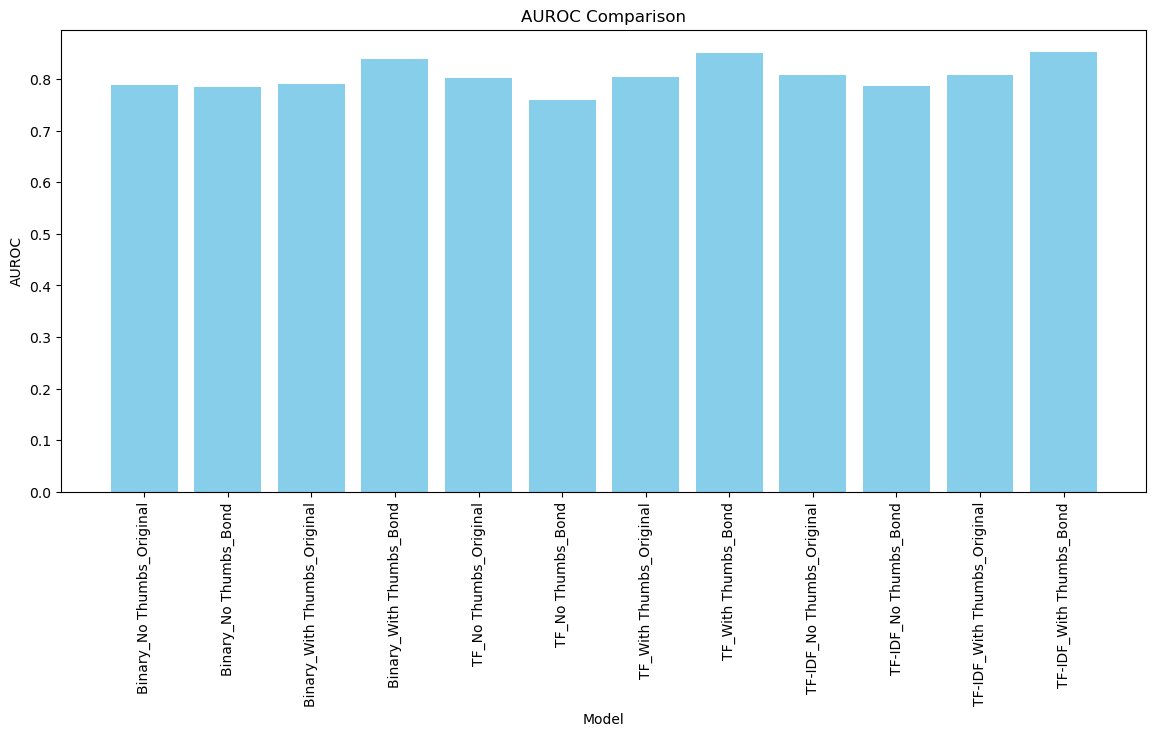

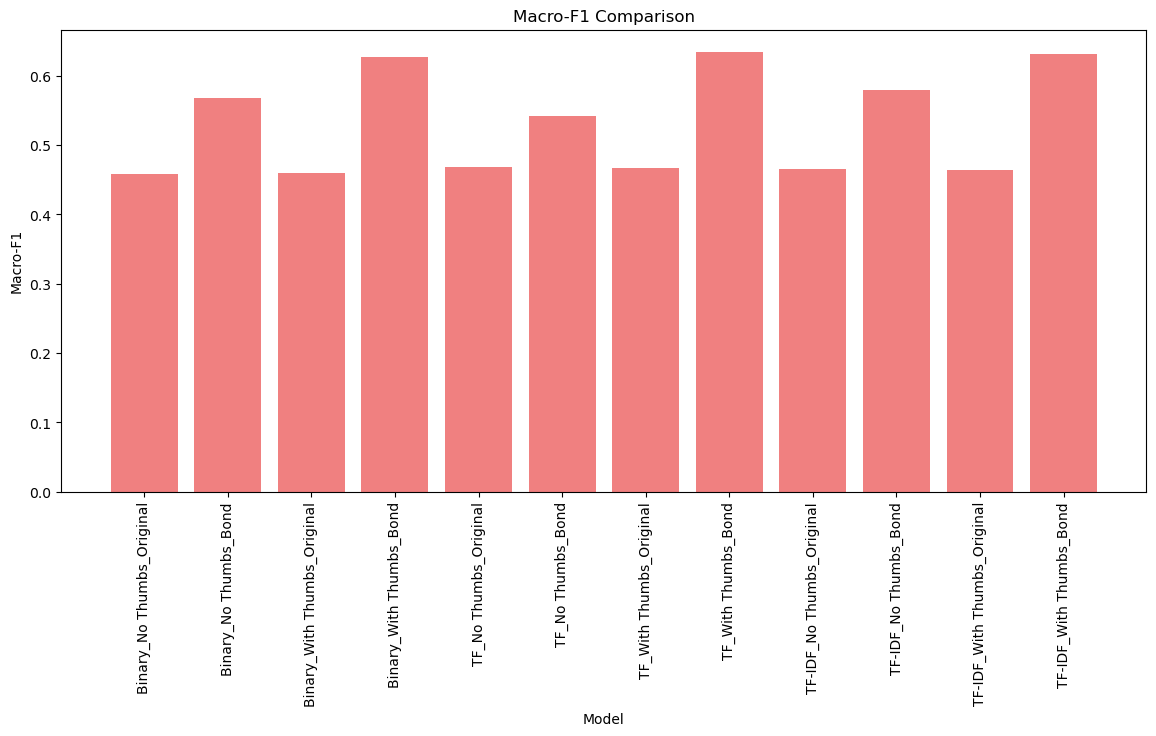

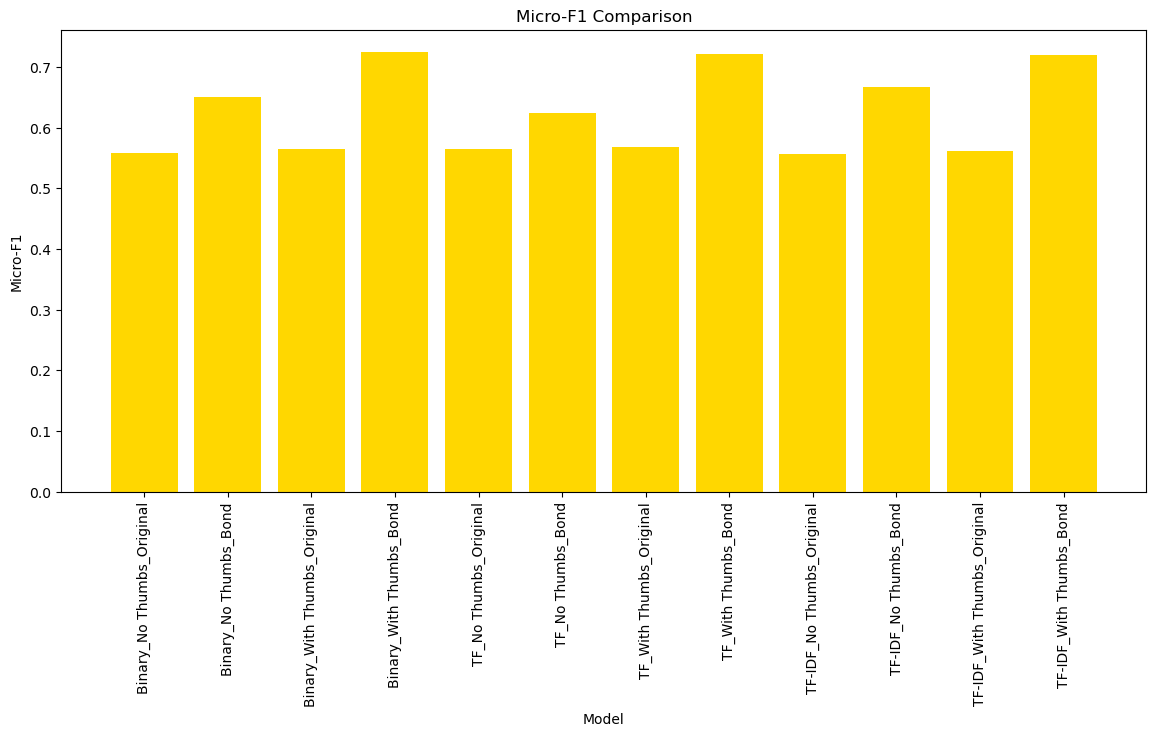

In [45]:
import matplotlib.pyplot as plt

# Plot AUROC
plt.figure(figsize=(14, 6))
plt.bar([f"{model}_{embedding}_{rating}" for model, embedding, rating in zip(compare_table['Model'], compare_table['Embedding'], compare_table['Rating'])], compare_table['AUROC'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('AUROC')
plt.title('AUROC Comparison')
plt.xticks(rotation=90)
plt.show()

# Plot Macro-F1
plt.figure(figsize=(14, 6))
plt.bar([f"{model}_{embedding}_{rating}" for model, embedding, rating in zip(compare_table['Model'], compare_table['Embedding'], compare_table['Rating'])], compare_table['Macro-F1'], color='lightcoral')
plt.xlabel('Model')
plt.ylabel('Macro-F1')
plt.title('Macro-F1 Comparison')
plt.xticks(rotation=90)
plt.show()

# Plot Micro-F1
plt.figure(figsize=(14, 6))
plt.bar([f"{model}_{embedding}_{rating}" for model, embedding, rating in zip(compare_table['Model'], compare_table['Embedding'], compare_table['Rating'])], compare_table['Micro-F1'], color='gold')
plt.xlabel('Model')
plt.ylabel('Micro-F1')
plt.title('Micro-F1 Comparison')
plt.xticks(rotation=90)
plt.show()

<h3>According to the result, the best model among binary, tf, and tf-idf, between original and bonded rating, between using thumbsUpCount and not using thumbsUpCount, the best model is using bonded rating with thumbsUpCount feature, and tf-idf as the vectorizer.

## Word2Vec

### Using original rating

In [46]:
from gensim.models import Word2Vec

def preprocess_text(text):
    return pre_processing_by_nltk(text)

sentences = [preprocess_text(doc) for doc in train_data['content']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def get_word2vec_embeddings(text, model, vector_size=100):
    words = preprocess_text(text)
    embeddings = np.zeros(vector_size)
    valid_words = 0
    for word in words:
        if word in model.wv:
            embeddings += model.wv[word]
            valid_words += 1
    if valid_words > 0:
        embeddings /= valid_words
    return embeddings

X_train_word2vec = np.array([get_word2vec_embeddings(doc, word2vec_model) for doc in train_data['content']])
X_test_word2vec = np.array([get_word2vec_embeddings(doc, word2vec_model) for doc in test_data['content']])

clf_word2vec = LogisticRegression(max_iter=1000, solver='saga', random_state=42, class_weight='balanced')
clf_word2vec.fit(X_train_word2vec, Y_train)

y_test_pred_word2vec = clf_word2vec.predict(X_test_word2vec)
y_test_proba_word2vec = clf_word2vec.predict_proba(X_test_word2vec)

auroc_word2vec_or = roc_auc_score(Y_test, y_test_proba_word2vec, multi_class="ovr")
macro_f1_word2vec_or = f1_score(Y_test, y_test_pred_word2vec, average='macro')
micro_f1_word2vec_or = f1_score(Y_test, y_test_pred_word2vec, average='micro')

print(f"Model: Word2Vec Representation")
print(f"Validation AUROC: {auroc_word2vec_or:.4f}")
print(f"Validation Macro-F1: {macro_f1_word2vec_or:.4f}")
print(f"Validation Micro-F1: {micro_f1_word2vec_or:.4f}")
print("-" * 50)

Model: Word2Vec Representation
Validation AUROC: 0.7905
Validation Macro-F1: 0.4456
Validation Micro-F1: 0.5385
--------------------------------------------------


## Using original rating with thumbsUpCount feature

In [47]:

def preprocess_text(text):
    return pre_processing_by_nltk(text)

sentences = [preprocess_text(doc) for doc in train_data['content']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def get_word2vec_embeddings(text, model, vector_size=100):
    words = preprocess_text(text)
    embeddings = np.zeros(vector_size)
    valid_words = 0
    for word in words:
        if word in model.wv:
            embeddings += model.wv[word]
            valid_words += 1
    if valid_words > 0:
        embeddings /= valid_words
    return embeddings

X_train_word2vec = np.array([get_word2vec_embeddings(doc, word2vec_model) for doc in train_data['content']])
X_test_word2vec = np.array([get_word2vec_embeddings(doc, word2vec_model) for doc in test_data['content']])

X_train_word2vec = np.hstack((X_train_word2vec, train_thumbs.reshape(-1, 1)))
X_test_word2vec = np.hstack((X_test_word2vec, test_thumbs.reshape(-1, 1)))

clf_word2vec = LogisticRegression(max_iter=1000, solver='saga', random_state=42, class_weight='balanced')
clf_word2vec.fit(X_train_word2vec, Y_train)

y_test_pred_word2vec = clf_word2vec.predict(X_test_word2vec)
y_test_proba_word2vec = clf_word2vec.predict_proba(X_test_word2vec)

auroc_word2vec_or_thumb = roc_auc_score(Y_test, y_test_proba_word2vec, multi_class="ovr")
macro_f1_word2vec_or_thumb = f1_score(Y_test, y_test_pred_word2vec, average='macro')
micro_f1_word2vec_or_thumb = f1_score(Y_test, y_test_pred_word2vec, average='micro')

print(f"Model: Word2Vec Representation with ThumbsUpCount")
print(f"Validation AUROC: {auroc_word2vec_or_thumb:.4f}")
print(f"Validation Macro-F1: {macro_f1_word2vec_or_thumb:.4f}")
print(f"Validation Micro-F1: {micro_f1_word2vec_or_thumb:.4f}")
print("-" * 50)

Model: Word2Vec Representation with ThumbsUpCount
Validation AUROC: 0.7414
Validation Macro-F1: 0.3952
Validation Micro-F1: 0.5279
--------------------------------------------------


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Using bonded rating

In [48]:
def preprocess_text(text):
    return pre_processing_by_nltk(text)

sentences = [preprocess_text(doc) for doc in train_data['content']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def get_word2vec_embeddings(text, model, vector_size=100):
    words = preprocess_text(text)
    embeddings = np.zeros(vector_size)
    valid_words = 0
    for word in words:
        if word in model.wv:
            embeddings += model.wv[word]
            valid_words += 1
    if valid_words > 0:
        embeddings /= valid_words
    return embeddings

X_train_word2vec = np.array([get_word2vec_embeddings(doc, word2vec_model) for doc in train_data['content']])
X_test_word2vec = np.array([get_word2vec_embeddings(doc, word2vec_model) for doc in test_data['content']])

clf_word2vec = LogisticRegression(max_iter=1000, solver='saga', random_state=42, class_weight='balanced')
clf_word2vec.fit(X_train_word2vec, Y_train_bond)

y_test_pred_word2vec = clf_word2vec.predict(X_test_word2vec)
y_test_proba_word2vec = clf_word2vec.predict_proba(X_test_word2vec)

auroc_word2vec_bon = roc_auc_score(Y_test_bond, y_test_proba_word2vec, multi_class="ovr")
macro_f1_word2vec_bon = f1_score(Y_test_bond, y_test_pred_word2vec, average='macro')
micro_f1_word2vec_bon = f1_score(Y_test_bond, y_test_pred_word2vec, average='micro')

print(f"Model: Word2Vec Representation with Bonded Rating")
print(f"Validation AUROC: {auroc_word2vec_bon:.4f}")
print(f"Validation Macro-F1: {macro_f1_word2vec_bon:.4f}")
print(f"Validation Micro-F1: {micro_f1_word2vec_bon:.4f}")
print("-" * 50)

Model: Word2Vec Representation with Bonded Rating
Validation AUROC: 0.8398
Validation Macro-F1: 0.6186
Validation Micro-F1: 0.6942
--------------------------------------------------


## Using bonded rating with thumbsUpCount feature

In [49]:
def preprocess_text(text):
    return pre_processing_by_nltk(text)

sentences = [preprocess_text(doc) for doc in train_data['content']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def get_word2vec_embeddings(text, model, vector_size=100):
    words = preprocess_text(text)
    embeddings = np.zeros(vector_size)
    valid_words = 0
    for word in words:
        if word in model.wv:
            embeddings += model.wv[word]
            valid_words += 1
    if valid_words > 0:
        embeddings /= valid_words
    return embeddings

X_train_word2vec = np.array([get_word2vec_embeddings(doc, word2vec_model) for doc in train_data['content']])
X_test_word2vec = np.array([get_word2vec_embeddings(doc, word2vec_model) for doc in test_data['content']])

X_train_word2vec = np.hstack((X_train_word2vec, train_thumbs.reshape(-1, 1)))
X_test_word2vec = np.hstack((X_test_word2vec, test_thumbs.reshape(-1, 1)))

clf_word2vec = LogisticRegression(max_iter=1000, solver='saga', random_state=42, class_weight='balanced')
clf_word2vec.fit(X_train_word2vec, Y_train_bond)

y_test_pred_word2vec = clf_word2vec.predict(X_test_word2vec)
y_test_proba_word2vec = clf_word2vec.predict_proba(X_test_word2vec)

auroc_word2vec_bon_thumb = roc_auc_score(Y_test_bond, y_test_proba_word2vec, multi_class="ovr")
macro_f1_word2vec_bon_thumb = f1_score(Y_test_bond, y_test_pred_word2vec, average='macro')
micro_f1_word2vec_bon_thumb = f1_score(Y_test_bond, y_test_pred_word2vec, average='micro')

print(f"Model: Word2Vec Representation with Bonded Rating and ThumbsUpCount")
print(f"Validation AUROC: {auroc_word2vec_bon_thumb:.4f}")
print(f"Validation Macro-F1: {macro_f1_word2vec_bon_thumb:.4f}")
print(f"Validation Micro-F1: {micro_f1_word2vec_bon_thumb:.4f}")
print("-" * 50)

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model: Word2Vec Representation with Bonded Rating and ThumbsUpCount
Validation AUROC: 0.7992
Validation Macro-F1: 0.5811
Validation Micro-F1: 0.6772
--------------------------------------------------


In [ ]:

word2vec_results = pd.DataFrame({
    'Model': ['Word2Vec', 'Word2Vec', 'Word2Vec', 'Word2Vec'],
    'Embedding': ['No Thumbs', 'With Thumbs', 'No Thumbs', 'With Thumbs'],
    'Rating': ['Original', 'Original', 'Bond', 'Bond'],
    'AUROC': [auroc_word2vec_or, auroc_word2vec_or_thumb, auroc_word2vec_bon, auroc_word2vec_bon_thumb],
    'Macro-F1': [macro_f1_word2vec_or, macro_f1_word2vec_or_thumb, macro_f1_word2vec_bon, macro_f1_word2vec_bon_thumb],
    'Micro-F1': [micro_f1_word2vec_or, micro_f1_word2vec_or_thumb, micro_f1_word2vec_bon, micro_f1_word2vec_bon_thumb]
})


new_compare_table = pd.concat([compare_table, word2vec_results], ignore_index=True)

new_compare_table

,Model,Embedding,Rating,AUROC,Macro-F1,Micro-F1
0,Binary,No Thumbs,Original,0.789166,0.458283,0.558685
1,Binary,No Thumbs,Bond,0.785819,0.567715,0.651014
2,Binary,With Thumbs,Original,0.791575,0.459451,0.564695
3,Binary,With Thumbs,Bond,0.838424,0.627293,0.725211
4,TF,No Thumbs,Original,0.802965,0.468347,0.564707
5,TF,No Thumbs,Bond,0.760310,0.542442,0.624208
6,TF,With Thumbs,Original,0.804852,0.467364,0.567752
7,TF,With Thumbs,Bond,0.849968,0.634647,0.721710
8,TF-IDF,No Thumbs,Original,0.807584,0.465352,0.557372
9,TF-IDF,No Thumbs,Bond,0.787360,0.579645,0.667633


In [ ]:
new_compare_table = new_compare_table.round(3)

new_compare_table

,Model,Embedding,Rating,AUROC,Macro-F1,Micro-F1
0,Binary,No Thumbs,Original,0.789,0.458,0.559
1,Binary,No Thumbs,Bond,0.786,0.568,0.651
2,Binary,With Thumbs,Original,0.792,0.459,0.565
3,Binary,With Thumbs,Bond,0.838,0.627,0.725
4,TF,No Thumbs,Original,0.803,0.468,0.565
5,TF,No Thumbs,Bond,0.760,0.542,0.624
6,TF,With Thumbs,Original,0.805,0.467,0.568
7,TF,With Thumbs,Bond,0.850,0.635,0.722
8,TF-IDF,No Thumbs,Original,0.808,0.465,0.557
9,TF-IDF,No Thumbs,Bond,0.787,0.580,0.668


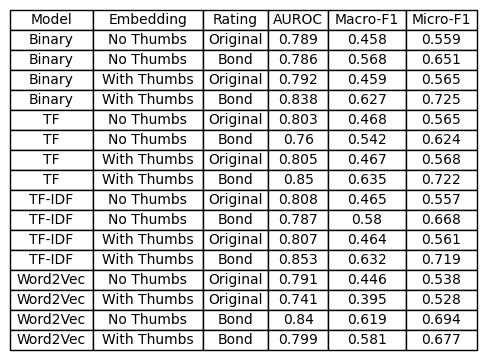

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

table = ax.table(cellText=new_compare_table.values, colLabels=new_compare_table.columns, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

col_widths = [0.1, 0.15, 0.1, 0.1, 0.1, 0.1]
for i, width in enumerate(col_widths):
    table.auto_set_column_width(i)
    for cell in table.get_celld().values():
        cell.set_width(width)

plt.savefig('new_compare_table.png', bbox_inches='tight', dpi=300)
plt.show()

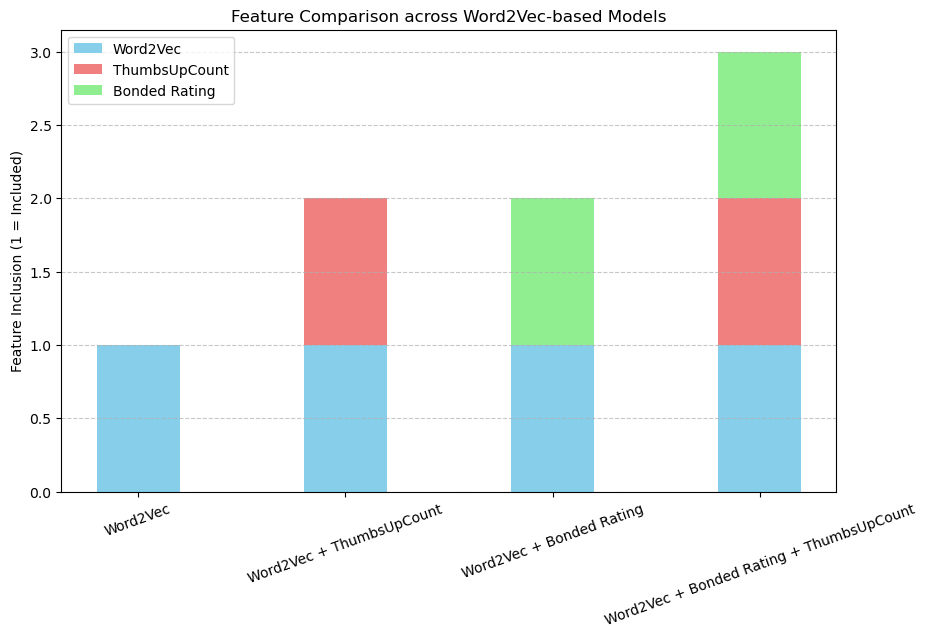

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

features = [
    "Word2Vec",
    "Word2Vec + ThumbsUpCount",
    "Word2Vec + Bonded Rating",
    "Word2Vec + Bonded Rating + ThumbsUpCount"
]

text_feature = [1, 1, 1, 1] 
thumbs_feature = [0, 1, 0, 1]  
bond_feature = [0, 0, 1, 1] 
bar_width = 0.4
x = np.arange(len(features))

ax.bar(x, text_feature, bar_width, label="Word2Vec", color="skyblue")
ax.bar(x, thumbs_feature, bar_width, bottom=text_feature, label="ThumbsUpCount", color="lightcoral")
ax.bar(x, bond_feature, bar_width, bottom=np.array(text_feature) + np.array(thumbs_feature), label="Bonded Rating", color="lightgreen")

ax.set_xticks(x)
ax.set_xticklabels(features, rotation=20)
ax.set_ylabel("Feature Inclusion (1 = Included)")
ax.set_title("Feature Comparison across Word2Vec-based Models")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

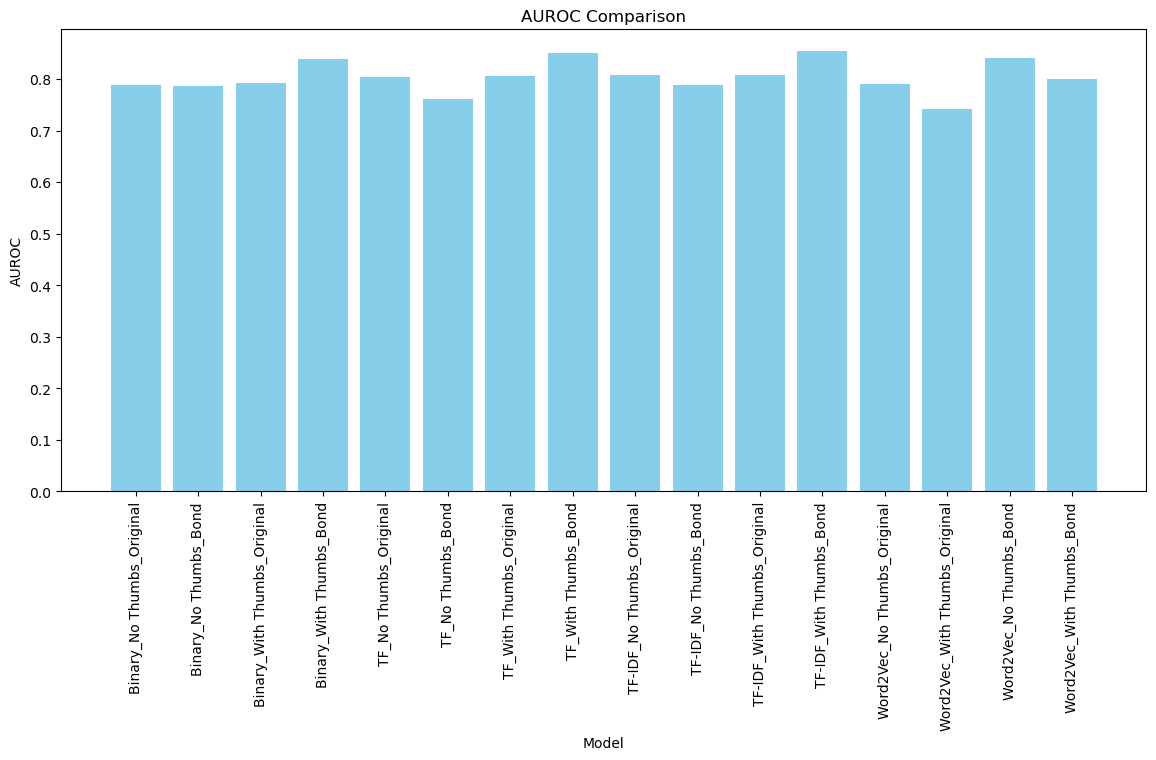

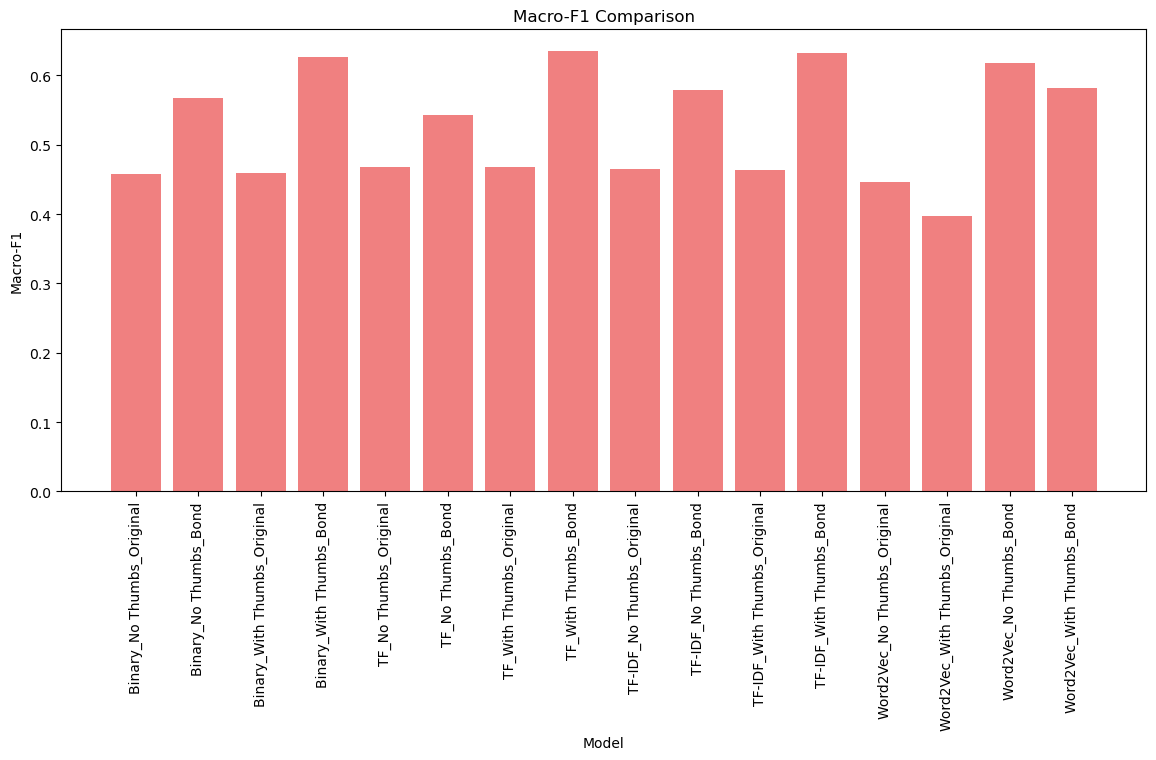

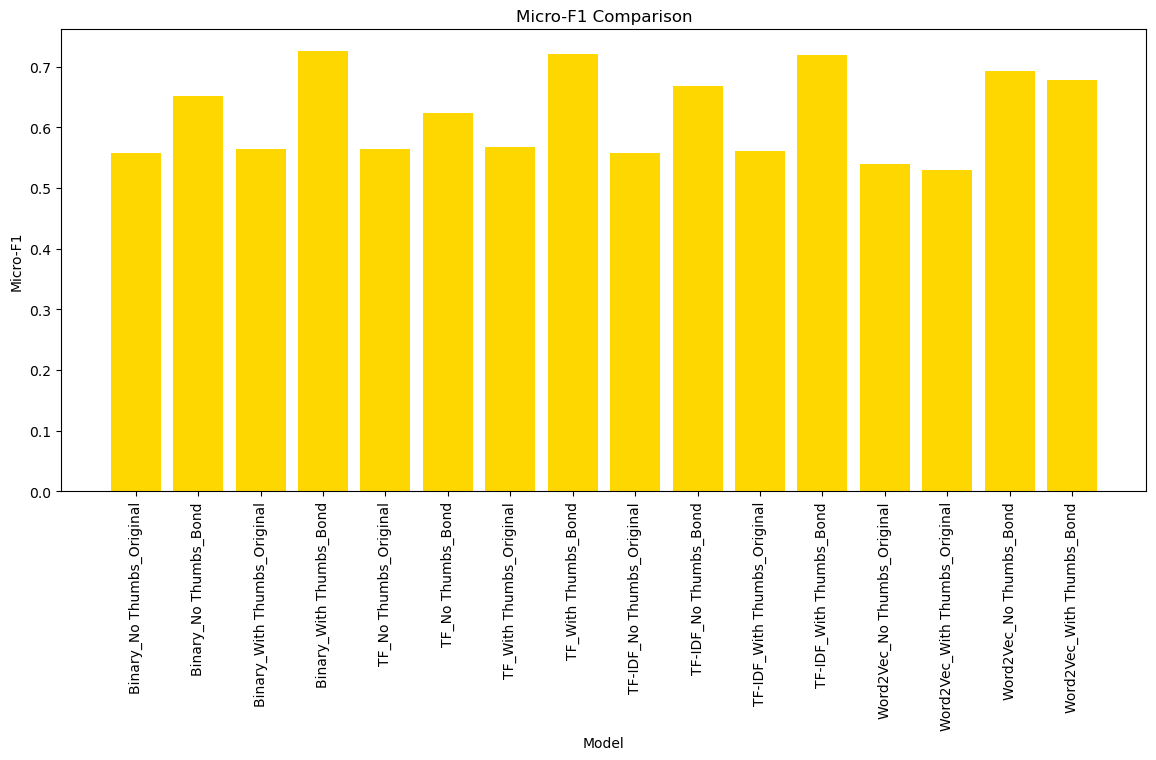

In [ ]:
plt.figure(figsize=(14, 6))
plt.bar([f"{model}_{embedding}_{rating}" for model, embedding, rating in zip(new_compare_table['Model'], new_compare_table['Embedding'], new_compare_table['Rating'])], new_compare_table['AUROC'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('AUROC')
plt.title('AUROC Comparison')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(14, 6))
plt.bar([f"{model}_{embedding}_{rating}" for model, embedding, rating in zip(new_compare_table['Model'], new_compare_table['Embedding'], new_compare_table['Rating'])], new_compare_table['Macro-F1'], color='lightcoral')
plt.xlabel('Model')
plt.ylabel('Macro-F1')
plt.title('Macro-F1 Comparison')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(14, 6))
plt.bar([f"{model}_{embedding}_{rating}" for model, embedding, rating in zip(new_compare_table['Model'], new_compare_table['Embedding'], new_compare_table['Rating'])], new_compare_table['Micro-F1'], color='gold')
plt.xlabel('Model')
plt.ylabel('Micro-F1')
plt.title('Micro-F1 Comparison')
plt.xticks(rotation=90)
plt.show()